### Analisis | Campañas



In [ ]:
# -------------------------
# A1) Asignacion del costo a cada campaña (por canal)
# -------------------------

# Proxy de costo diario por canal (no se cuenta con gasto real)
costos_diarios_canal <- tibble(
  canal = c("Email", "Display", "Social", "Paid Search", "Affiliate"),
  costo_diario = c(80, 120, 180, 250, 120)
)

campanias_costeadas <- campaigns %>%
  mutate(
    fecha_inicio  = as.Date(start_date),
    fecha_fin     = as.Date(end_date),
    duracion_dias = as.integer(fecha_fin - fecha_inicio) + 1L
  ) %>%
  left_join(costos_diarios_canal, by = c("channel" = "canal")) %>%
  mutate(
    costo_diario   = coalesce(costo_diario, 200),
    costo_estimado = duracion_dias * costo_diario
  ) %>%
  select(campaign_id, channel, objective, fecha_inicio, fecha_fin, costo_estimado)

In [ ]:
# -------------------------
# A2) Transacciones atribuibles (campaña + 14 días)
# -------------------------
tx_atrib <- tx %>%
  filter(refund_flag == 0) %>%
  mutate(
    fecha_tx = as.Date(timestamp),
    ingresos = gross_revenue
  ) %>%
  left_join(
    campanias_costeadas %>% select(campaign_id, fecha_inicio, fecha_fin, costo_estimado),
    by = "campaign_id"
  ) %>%
  filter(!is.na(fecha_inicio)) %>%
  filter(fecha_tx >= fecha_inicio, fecha_tx <= fecha_fin + days(14))

transacciones_atribuidas <- tx_atrib %>%
  group_by(campaign_id) %>%
  summarise(
    ingresos = sum(ingresos, na.rm = TRUE),
    compradores = n_distinct(customer_id),
    .groups = "drop"
  )

In [ ]:
# -------------------------
# A3) KPIs campaña + KPIs canal
# -------------------------

kpis_campania <- campanias_costeadas %>%
  left_join(transacciones_atribuidas, by = "campaign_id") %>%
  mutate(
    ingresos    = coalesce(ingresos, 0),
    compradores = coalesce(compradores, 0),
    roi  = if_else(costo_estimado > 0, (ingresos - costo_estimado) / costo_estimado, NA_real_),
    roas = if_else(costo_estimado > 0, ingresos / costo_estimado, NA_real_),
    cpa  = if_else(compradores > 0, costo_estimado / compradores, NA_real_)
  )

kpis_canal <- kpis_campania %>%
  group_by(channel) %>%
  summarise(
    ingresos = sum(ingresos, na.rm = TRUE),
    costo    = sum(costo_estimado, na.rm = TRUE),
    roi      = if_else(costo > 0, (ingresos - costo) / costo, NA_real_),
    roas     = if_else(costo > 0, ingresos / costo, NA_real_),
    .groups = "drop"
  ) %>%
  arrange(desc(roi))

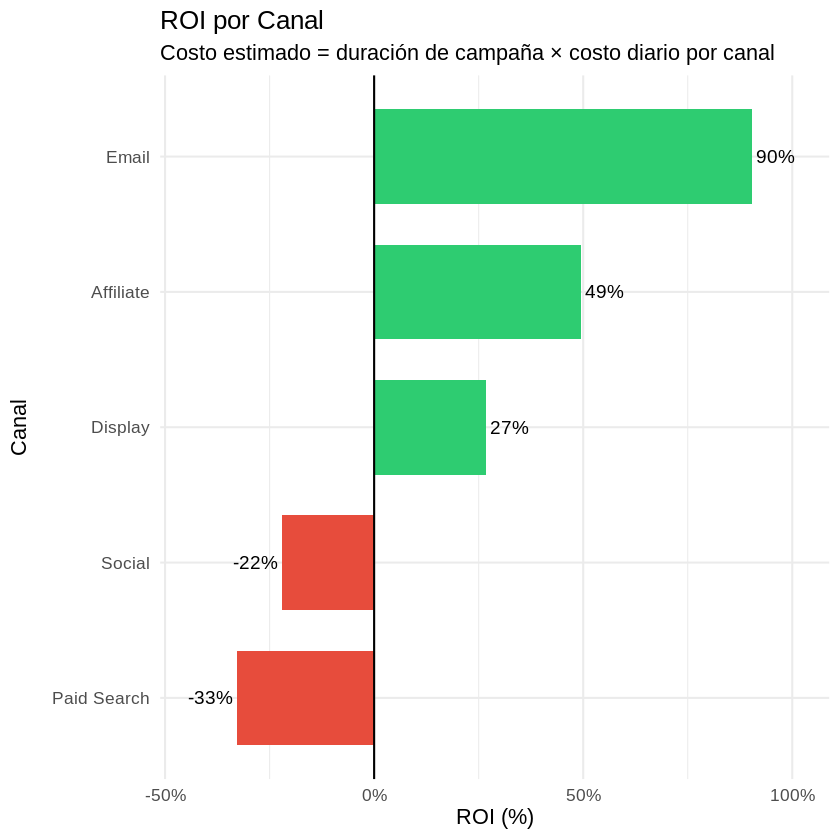

In [ ]:
# -------------------------
# A4) ROI por canal
# -------------------------

ggplot(kpis_canal, aes(x = reorder(channel, roi), y = roi, fill = roi > 0)) +
  geom_col(width = 0.7) +
  geom_hline(yintercept = 0, color = "black") +
  geom_text(
    aes(
      label = percent(roi, accuracy = 1),
      hjust = if_else(roi > 0, -0.1, 1.1)
    ),
    color = "black", size = 4
  ) +
  coord_flip() +
  scale_y_continuous(labels = percent, expand = expansion(mult = c(0.15, 0.15))) +
  scale_fill_manual(values = c("TRUE" = "#2ecc71", "FALSE" = "#e74c3c"), guide = "none") +
  labs(
    title = "ROI por Canal",
    subtitle = "Costo estimado = duración de campaña × costo diario por canal",
    x = "Canal", y = "ROI (%)"
  ) +
  theme_minimal(base_size = 13)

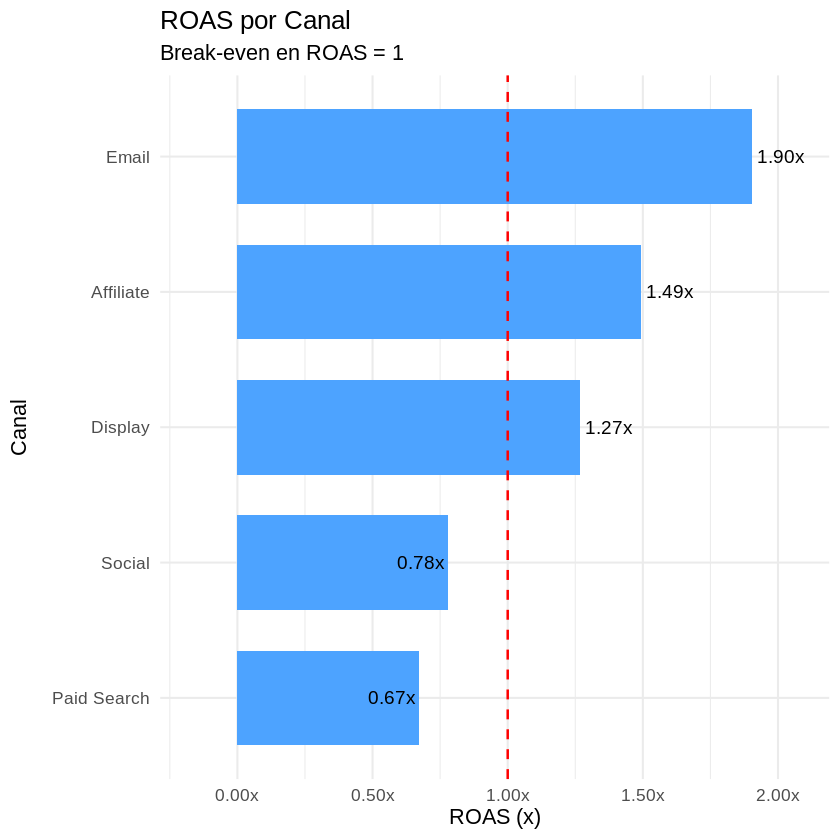

In [ ]:
# -------------------------
# A5) ROAS por canal
# -------------------------

ggplot(kpis_canal, aes(x = reorder(channel, roas), y = roas)) +
  geom_col(width = 0.7, fill = "#4da3ff") +
  geom_hline(yintercept = 1, linetype = "dashed", color = "red", linewidth = 0.7) +
  geom_text(
    aes(
      label = sprintf("%.2fx", roas),
      hjust = if_else(roas >= 1, -0.1, 1.1)
    ),
    color = "black", size = 4
  ) +
  coord_flip() +
  scale_y_continuous(
    labels = label_number(accuracy = 0.01, suffix = "x"),
    expand = expansion(mult = c(0.15, 0.15))
  ) +
  labs(
    title = "ROAS por Canal",
    subtitle = "Break-even en ROAS = 1",
    x = "Canal", y = "ROAS (x)"
  ) +
  theme_minimal(base_size = 13)


In [ ]:
# -------------------------
# A6) TOP/BOTTOM 5 campañas por ROI
# -------------------------

kpis_campania_validas <- kpis_campania %>% filter(!is.na(roi))

top_5_roi <- kpis_campania_validas %>%
  arrange(desc(roi)) %>%
  slice_head(n = 5) %>%
  mutate(campania = paste0("C", campaign_id))

bottom_5_roi <- kpis_campania_validas %>%
  arrange(roi) %>%
  slice_head(n = 5) %>%
  mutate(campania = paste0("C", campaign_id))

tabla_top10_roi <- kpis_campania_validas %>%
  arrange(desc(roi)) %>%
  slice_head(n = 10) %>%
  mutate(
    campaña = paste0("C", campaign_id),
    ingresos = dollar(ingresos),
    costo_estimado = dollar(costo_estimado),
    roi = percent(roi, accuracy = 1),
    roas = round(roas, 2)
  ) %>%
  select(campaña, channel, objective, ingresos, costo_estimado, roi, roas)


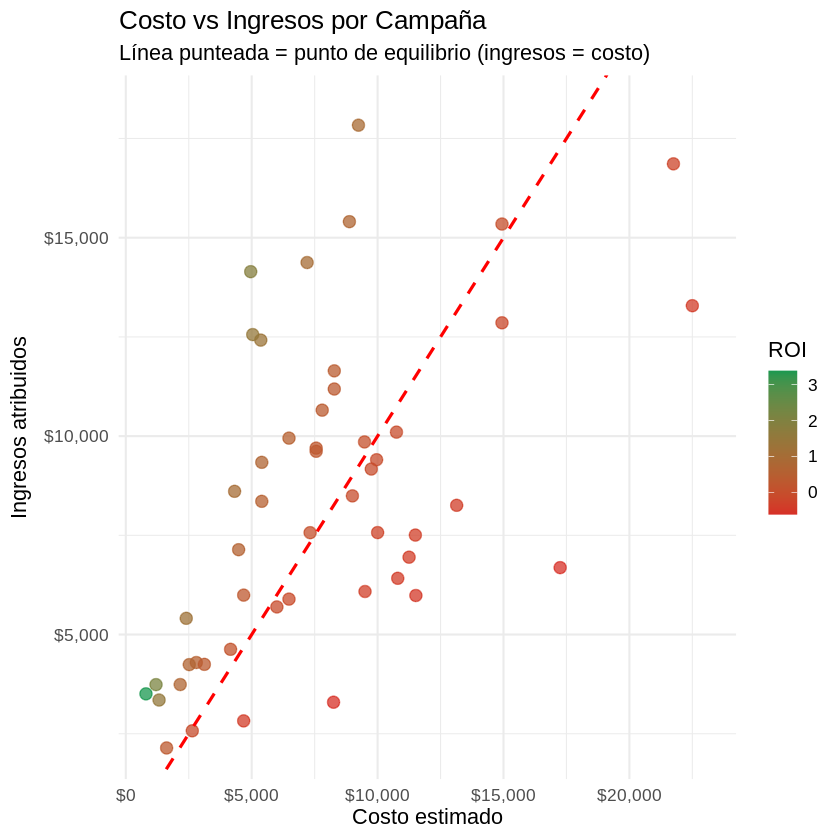

In [ ]:
# -------------------------
# A7) Scatter costo vs ingresos (campañas)
# -------------------------

ggplot(kpis_campania_validas, aes(x = costo_estimado, y = ingresos, color = roi)) +
  geom_point(alpha = 0.75, size = 3) +
  geom_abline(intercept = 0, slope = 1, linetype = "dashed", color = "red", linewidth = 0.9) +
  scale_x_continuous(labels = dollar_format(), expand = expansion(mult = c(0.05, 0.08))) +
  scale_y_continuous(labels = dollar_format(), expand = expansion(mult = c(0.05, 0.08))) +
  scale_color_gradient(low = "#d73027", high = "#1a9850", name = "ROI") +
  labs(
    title = "Costo vs Ingresos por Campaña",
    subtitle = "Línea punteada = punto de equilibrio (ingresos = costo)",
    x = "Costo estimado", y = "Ingresos atribuidos"
  ) +
  theme_minimal(base_size = 13)


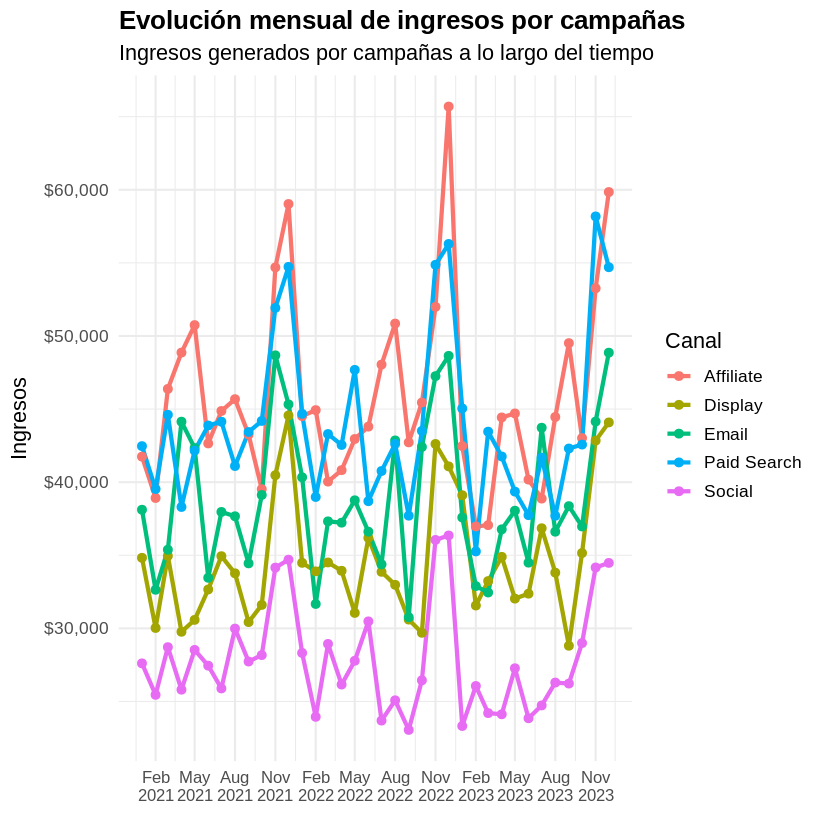

In [ ]:
# -------------------------
# A8) Evolución mensual de ingresos por canal
# -------------------------

ingresos_mensuales_camp <- tx %>%
  filter(!is.na(timestamp), !is.na(gross_revenue), !is.na(campaign_id)) %>%
  mutate(mes = floor_date(as.Date(timestamp), "month")) %>%
  group_by(mes, campaign_id) %>%
  summarise(ingresos = sum(gross_revenue, na.rm = TRUE), .groups = "drop")

ingresos_mensuales_canal <- ingresos_mensuales_camp %>%
  left_join(campaigns %>% select(campaign_id, channel), by = "campaign_id") %>%
  filter(!is.na(channel)) %>%
  group_by(mes, channel) %>%
  summarise(ingresos = sum(ingresos), .groups = "drop")

ggplot(ingresos_mensuales_canal, aes(x = mes, y = ingresos, color = channel)) +
  geom_line(linewidth = 1.2) +
  geom_point(size = 2) +
  scale_y_continuous(labels = dollar_format()) +
  scale_x_date(date_labels = "%b\n%Y", date_breaks = "3 months") +
  labs(
    title = "Evolución mensual de ingresos por campañas",
    subtitle = "Ingresos generados por campañas a lo largo del tiempo",
    x = "", y = "Ingresos", color = "Canal"
  ) +
  theme_minimal(base_size = 13) +
  theme(
    plot.title = element_text(face = "bold"),
    axis.text.x = element_text(size = 10)
  )

## Analisis | Productos

In [ ]:
# ------------------------------------------------------------
# B1) Asignamos costo de campaña a transacciones (revenue-share)
# ------------------------------------------------------------

tx_costeada <- tx_atrib %>%
  group_by(campaign_id) %>%
  mutate(
    ingresos_campania = sum(ingresos, na.rm = TRUE),
    costo_tx = if_else(
      !is.na(costo_estimado) & ingresos_campania > 0,
      costo_estimado * (ingresos / ingresos_campania),
      NA_real_
    )
  ) %>%
  ungroup()

# Aseguro que products no duplique filas al joinear
products_dim <- products %>%
  distinct(product_id, category, brand, is_premium)

kpi_productos <- tx_costeada %>%
  left_join(products_dim, by = "product_id") %>%
  group_by(product_id) %>%
  summarise(
    categoria = first(category),
    marca     = first(brand),
    premium   = first(is_premium),
    ingresos  = sum(ingresos, na.rm = TRUE),

    # Si no hay ningún costo asignable, lo dejo como NA (no como 0)
    costo_marketing_asignado = if_else(
      all(is.na(costo_tx)),
      NA_real_,
      sum(costo_tx, na.rm = TRUE)
    ),

    unidades_vendidas = sum(quantity, na.rm = TRUE),
    compradores       = n_distinct(customer_id),
    pedidos           = n(),

    ticket_promedio = if_else(pedidos > 0, ingresos / pedidos, NA_real_),
    roas = if_else(!is.na(costo_marketing_asignado) & costo_marketing_asignado > 0,
                   ingresos / costo_marketing_asignado, NA_real_),
    roi  = if_else(!is.na(costo_marketing_asignado) & costo_marketing_asignado > 0,
                   (ingresos - costo_marketing_asignado) / costo_marketing_asignado, NA_real_),
    .groups = "drop"
  )


In [ ]:
# ------------------------------------------------------------
# B2) Clustering por umbrales (mediana ingresos, ROI=0)
# ------------------------------------------------------------

umbral_ingresos <- median(kpi_productos$ingresos, na.rm = TRUE)
umbral_roi <- 0

kpi_productos_cluster <- kpi_productos %>%
  mutate(
    cluster_producto = case_when(
      ingresos >= umbral_ingresos & roi >= umbral_roi ~ "⭐ Producto estrella",
      ingresos >= umbral_ingresos & roi <  umbral_roi ~ "⚠️ Volumen poco rentable",
      ingresos <  umbral_ingresos & roi >= umbral_roi ~ "💎 Oportunidad",
      TRUE                                           ~ "❌ Producto prescindible"
    )
  )

matriz_df <- kpi_productos_cluster %>%
  filter(!is.na(ingresos), !is.na(roi), !is.na(unidades_vendidas), ingresos > 0) %>%
  mutate(
    tipo_producto = factor(
      cluster_producto,
      levels = c("⚠️ Volumen poco rentable", "❌ Producto prescindible", "⭐ Producto estrella", "💎 Oportunidad")
    )
  )



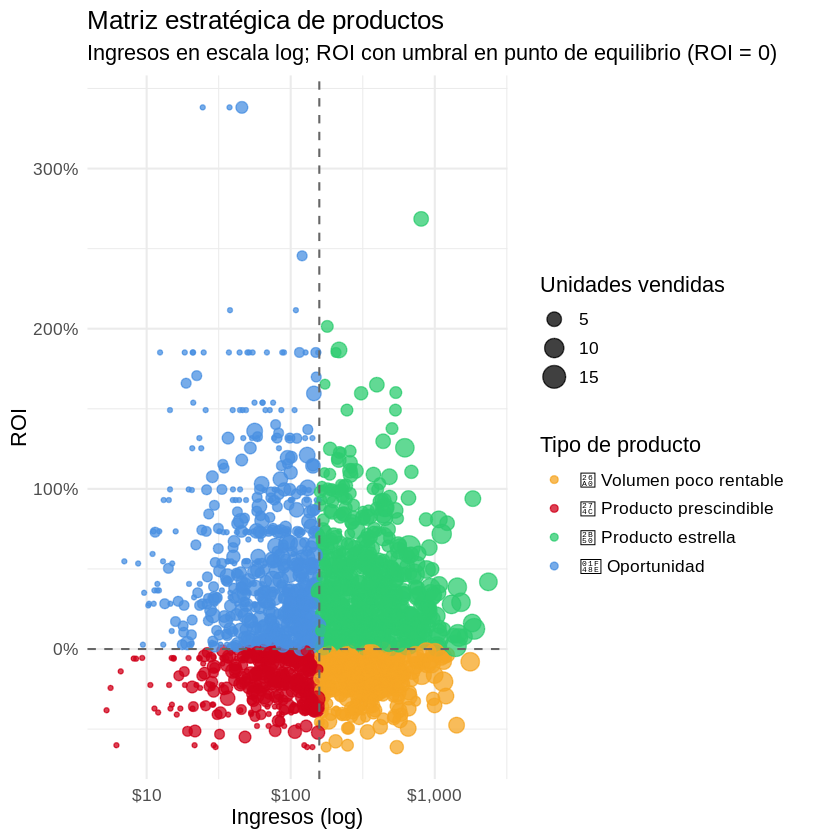

In [ ]:
# ------------------------------------------------------------
# B3) Matriz estratégica (ingresos log, ROI lineal)
# ------------------------------------------------------------

ggplot(matriz_df, aes(x = ingresos, y = roi, color = tipo_producto, size = unidades_vendidas)) +
  geom_point(alpha = 0.75) +
  geom_vline(xintercept = umbral_ingresos, linetype = "dashed", color = "grey40") +
  geom_hline(yintercept = umbral_roi,      linetype = "dashed", color = "grey40") +
  scale_x_log10(labels = dollar_format()) +
  scale_y_continuous(labels = percent_format(accuracy = 1)) +
  scale_color_manual(values = c(
    "⚠️ Volumen poco rentable" = "#f5a623",
    "❌ Producto prescindible" = "#d0021b",
    "⭐ Producto estrella"     = "#2ecc71",
    "💎 Oportunidad"           = "#4a90e2"
  )) +
  labs(
    title = "Matriz estratégica de productos",
    subtitle = "Ingresos en escala log; ROI con umbral en punto de equilibrio (ROI = 0)",
    x = "Ingresos (log)", y = "ROI",
    color = "Tipo de producto", size = "Unidades vendidas"
  ) +
  theme_minimal(base_size = 13) +
  theme(legend.position = "right")

cluster_producto,productos,ingresos_totales,ingresos_promedio,roi_promedio,unidades_totales,participacion_ingresos
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
⭐ Producto estrella,571,229051.51,401.14100,0.4198301,2553,0.54941177
⚠️ Volumen poco rentable,320,118883.83,371.51197,-0.1826730,1377,0.28515933
💎 Oportunidad,568,43932.40,77.34577,0.5570958,1371,0.10537795
❌ Producto prescindible,323,25035.43,77.50907,-0.2020310,787,0.06005095


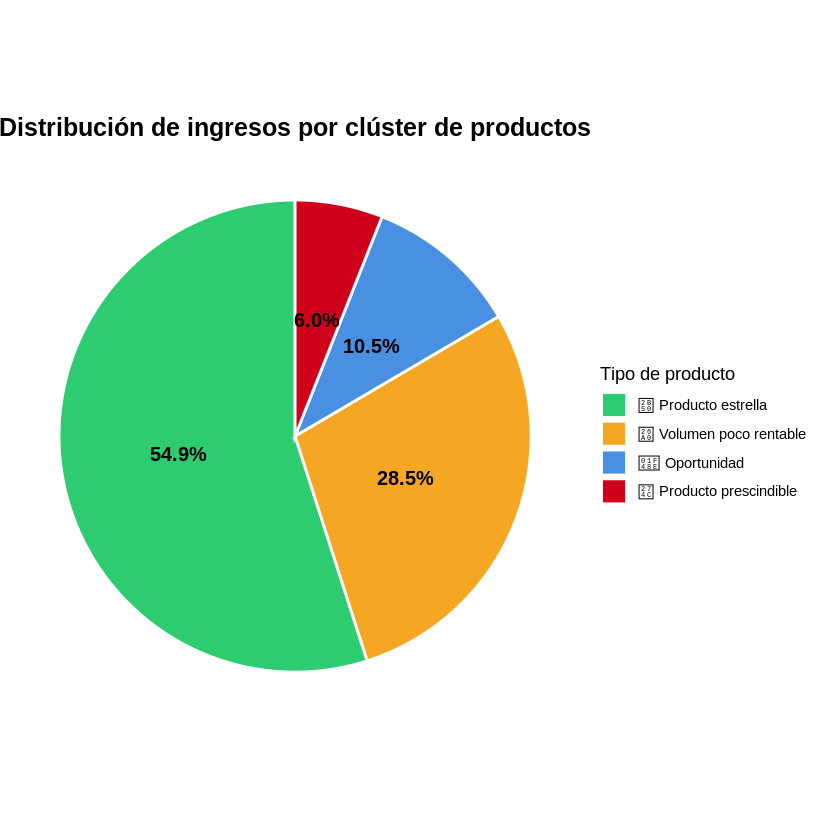

In [ ]:
# ------------------------------------------------------------
# B4) Resumen de clúster + distribución de ingresos (pie)
# ------------------------------------------------------------

resumen_clusters <- kpi_productos_cluster %>%
  filter(!is.na(cluster_producto)) %>%
  group_by(cluster_producto) %>%
  summarise(
    productos         = n_distinct(product_id),
    ingresos_totales  = sum(ingresos, na.rm = TRUE),
    ingresos_promedio = mean(ingresos, na.rm = TRUE),
    roi_promedio      = mean(roi, na.rm = TRUE),
    unidades_totales  = sum(unidades_vendidas, na.rm = TRUE),
    .groups = "drop"
  ) %>%
  mutate(participacion_ingresos = ingresos_totales / sum(ingresos_totales)) %>%
  arrange(desc(ingresos_totales))

pie_df <- resumen_clusters %>%
  mutate(cluster_producto = fct_reorder(cluster_producto, participacion_ingresos, .desc = TRUE))

ggplot(pie_df, aes(x = "", y = participacion_ingresos, fill = cluster_producto)) +
  geom_col(width = 1, color = "white", linewidth = 0.8) +
  coord_polar(theta = "y") +
  scale_fill_manual(values = c(
    "⚠️ Volumen poco rentable" = "#f5a623",
    "❌ Producto prescindible" = "#d0021b",
    "⭐ Producto estrella"     = "#2ecc71",
    "💎 Oportunidad"           = "#4a90e2"
  )) +
  geom_text(aes(label = percent(participacion_ingresos, accuracy = 0.1)),
            position = position_stack(vjust = 0.5),
            color = "black", size = 4.2, fontface = "bold") +
  labs(title = "Distribución de ingresos por clúster de productos", fill = "Tipo de producto") +
  theme_void() +
  theme(plot.title = element_text(size = 15, face = "bold", hjust = 0.5),
        legend.position = "right")
pie_df

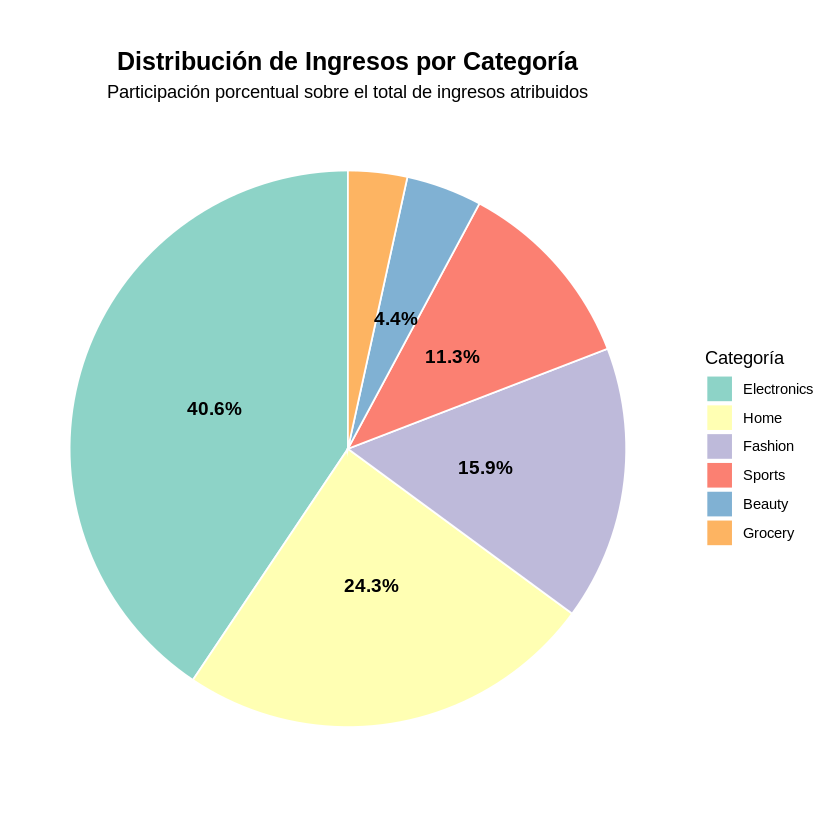

In [ ]:
# ------------------------------------------------------------
# B5) Distribución de ingresos por categoría
# ------------------------------------------------------------

resumen_categoria <- kpi_productos %>%
  group_by(categoria) %>%
  summarise(ingresos_totales = sum(ingresos, na.rm = TRUE), .groups = "drop") %>%
  mutate(
    participacion = ingresos_totales / sum(ingresos_totales),
    label = percent(participacion, accuracy = 0.1)
  ) %>%
  arrange(desc(participacion))

ggplot(resumen_categoria, aes(x = "", y = participacion, fill = reorder(categoria, -participacion))) +
  geom_col(width = 1, color = "white", linewidth = 0.5) +
  coord_polar(theta = "y") +
  scale_fill_brewer(palette = "Set3") +
  geom_text(aes(label = if_else(participacion > 0.04, label, "")),
            position = position_stack(vjust = 0.5),
            color = "black", size = 4, fontface = "bold") +
  labs(
    title = "Distribución de Ingresos por Categoría",
    subtitle = "Participación porcentual sobre el total de ingresos atribuidos",
    fill = "Categoría"
  ) +
  theme_void() +
  theme(
    plot.title = element_text(size = 15, face = "bold", hjust = 0.5),
    plot.subtitle = element_text(size = 11, hjust = 0.5),
    legend.position = "right"
  )

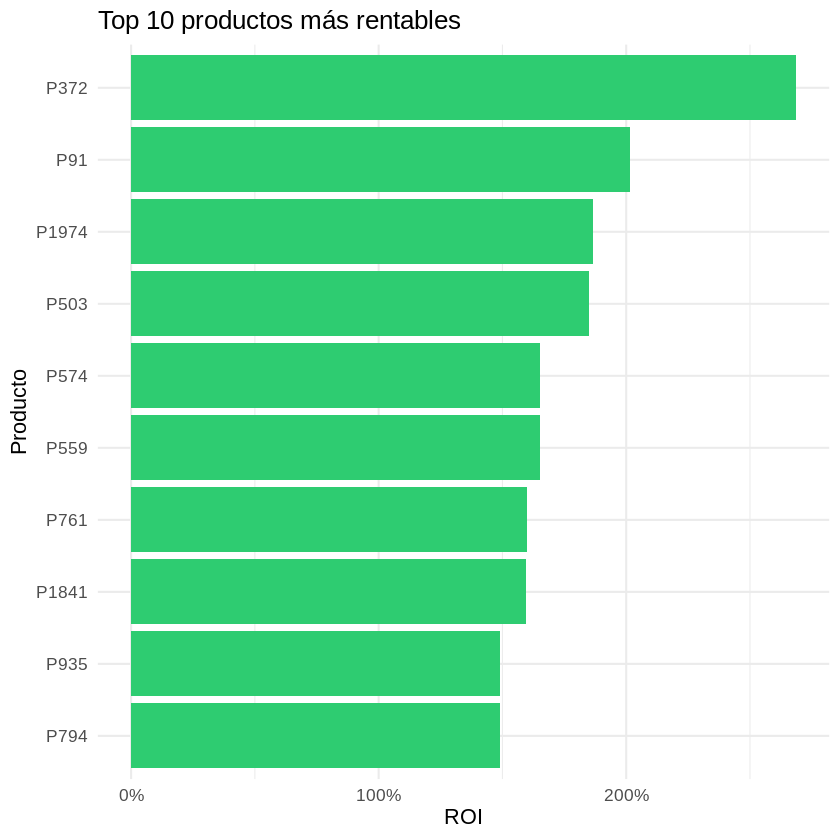

In [ ]:
# ------------------------------------------------------------
# B6) Top 10 productos más rentables (filtrando por ingresos)
# ------------------------------------------------------------

min_ingresos_rentables <- quantile(kpi_productos_cluster$ingresos, 0.50, na.rm = TRUE)

top10_mas_rentables <- kpi_productos_cluster %>%
  filter(!is.na(roi), !is.na(ingresos), ingresos >= min_ingresos_rentables) %>%
  arrange(desc(roi), desc(ingresos)) %>%
  slice_head(n = 10)

ggplot(top10_mas_rentables, aes(x = reorder(paste0("P", product_id), roi), y = roi)) +
  geom_col(fill = "#2ecc71") +
  coord_flip() +
  scale_y_continuous(labels = percent_format(accuracy = 1)) +
  labs(title = "Top 10 productos más rentables", x = "Producto", y = "ROI") +
  theme_minimal(base_size = 13)

roi_promedio_top10 <- top10_mas_rentables %>%
  summarise(roi_promedio = mean(roi, na.rm = TRUE)) %>%
  mutate(roi_promedio = percent(roi_promedio, accuracy = 0.1))

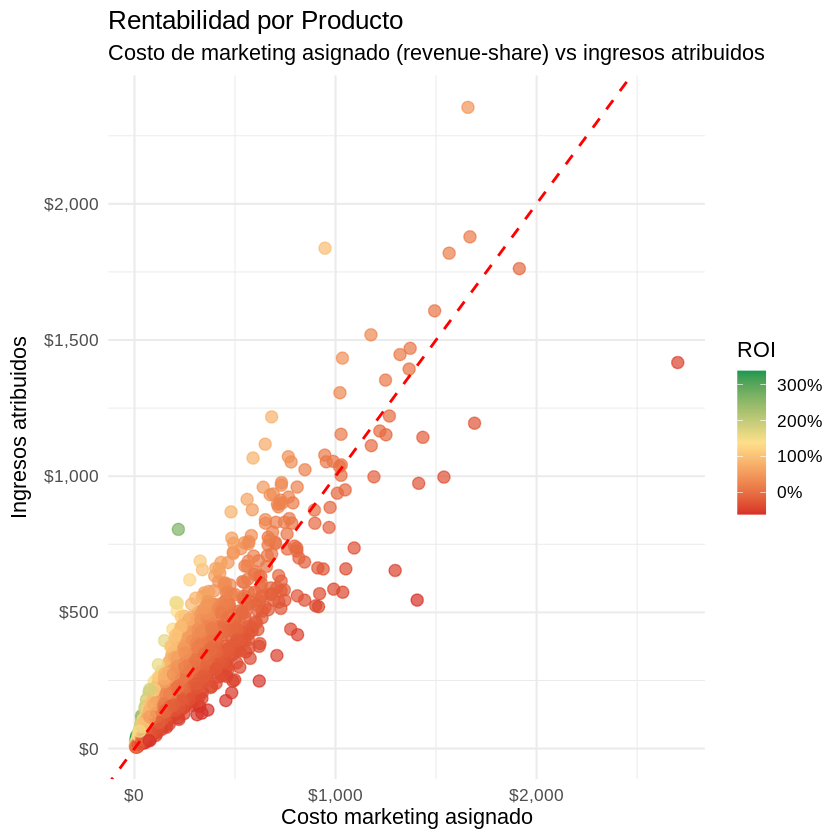

In [ ]:
# ------------------------------------------------------------
# B7) Scatter: costo asignado vs ingresos por producto
# ------------------------------------------------------------

ggplot(kpi_productos, aes(x = costo_marketing_asignado, y = ingresos, color = roi)) +
  geom_point(alpha = 0.7, size = 3) +
  geom_abline(intercept = 0, slope = 1, linetype = "dashed", color = "red", linewidth = 0.8) +
  scale_x_continuous(labels = dollar_format()) +
  scale_y_continuous(labels = dollar_format()) +
  scale_color_gradientn(colors = c("#d73027", "#fee08b", "#1a9850"),
                        name = "ROI", labels = percent) +
  labs(
    title = "Rentabilidad por Producto",
    subtitle = "Costo de marketing asignado (revenue-share) vs ingresos atribuidos",
    x = "Costo marketing asignado",
    y = "Ingresos atribuidos"
  ) +
  theme_minimal(base_size = 13)

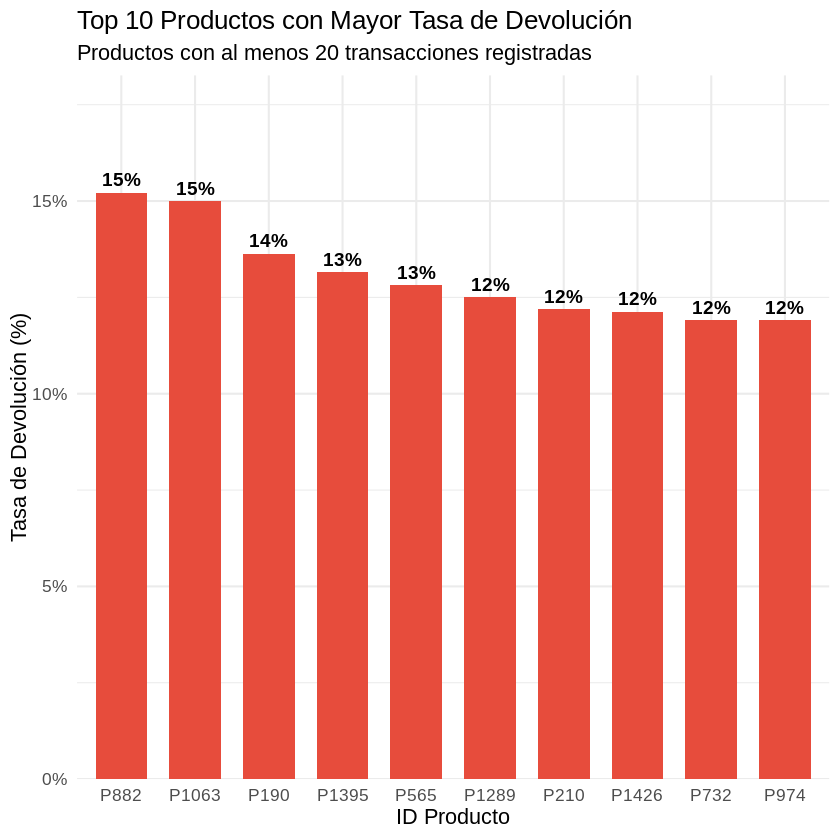

In [ ]:
# -------------------------
# B8) Análisis de Devoluciones (Refunds)
# -------------------------

# Usamos la base original 'transactions' para no perder los flags de reembolso
refunds_producto <- transactions %>%
  filter(!is.na(product_id)) %>%
  group_by(product_id) %>%
  summarise(
    transacciones_totales   = n(),
    transacciones_devueltas = sum(refund_flag == 1, na.rm = TRUE),
    tasa_devolucion         = transacciones_devueltas / transacciones_totales,
    .groups = "drop"
  )

# Filtramos productos con volumen representativo (ej. > 20 tx) para evitar ruido
top_productos_devoluciones <- refunds_producto %>%
  filter(transacciones_totales >= 20) %>%
  arrange(desc(tasa_devolucion)) %>%
  slice_head(n = 10) %>%
  mutate(
    producto = paste0("P", product_id)
  )

# Gráfico de Tasa de Devolución
ggplot(top_productos_devoluciones,
       aes(x = reorder(producto, -tasa_devolucion), y = tasa_devolucion)) +
  geom_col(fill = "#e74c3c", width = 0.7) +
  geom_text(aes(label = percent(tasa_devolucion, accuracy = 1)),
            vjust = -0.5, size = 4, fontface = "bold") +
  scale_y_continuous(labels = percent, expand = expansion(mult = c(0, 0.2))) +
  labs(
    title = "Top 10 Productos con Mayor Tasa de Devolución",
    subtitle = "Productos con al menos 20 transacciones registradas",
    x = "ID Producto",
    y = "Tasa de Devolución (%)"
  ) +
  theme_minimal(base_size = 13)

# Devoluciones por Categoría

refunds_categoria <- transactions %>%
  filter(!is.na(product_id)) %>%
  left_join(products %>% select(product_id, category), by = "product_id") %>%
  group_by(category) %>%
  summarise(
    total_tx = n(),
    total_refunds = sum(refund_flag == 1, na.rm = TRUE),
    tasa_devolucion = total_refunds / total_tx,
    .groups = "drop"
  ) %>%
  arrange(desc(tasa_devolucion))


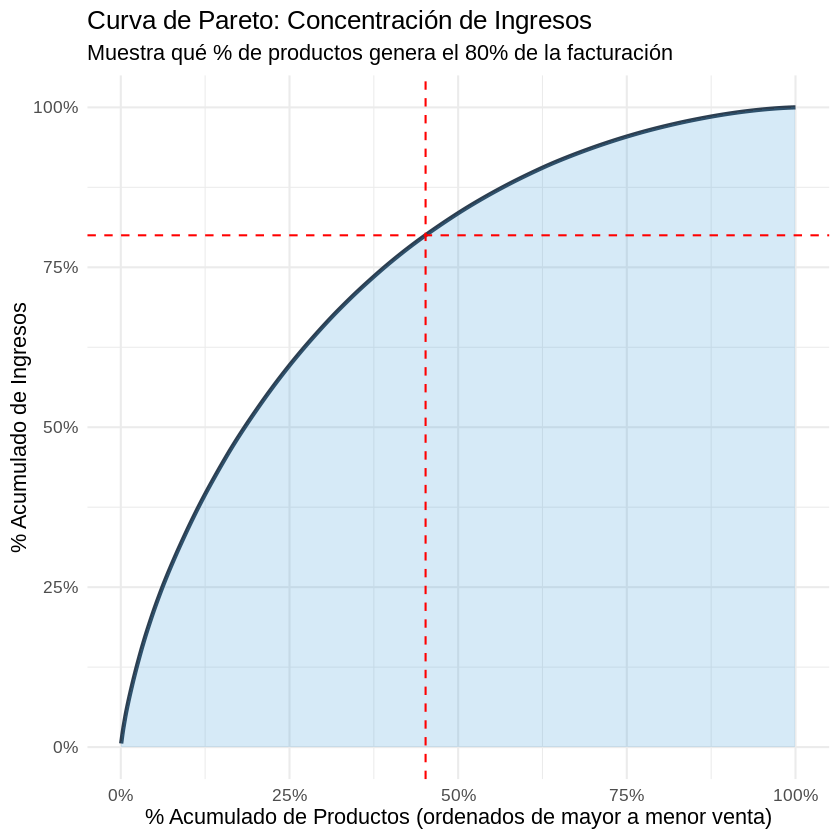

In [ ]:
# -------------------------
# B9) Analisis de Pareto para productos
# -------------------------
pareto_prod_data <- kpi_productos %>%
  arrange(desc(ingresos)) %>%
  mutate(
    row_id = row_number(),
    pct_cum_productos = row_id / n(),
    ingresos_acum = cumsum(ingresos),
    pct_cum_ingresos = ingresos_acum / sum(ingresos)
  )

# Gráfico de Curva de Pareto
ggplot(pareto_prod_data, aes(x = pct_cum_productos, y = pct_cum_ingresos)) +
  geom_line(color = "#2c3e50", size = 1.2) +
  geom_area(fill = "#3498db", alpha = 0.2) +
  # Línea del 80% de ingresos
  geom_hline(yintercept = 0.8, linetype = "dashed", color = "red") +
  # Punto de intersección aproximado
  geom_vline(xintercept = pareto_prod_data$pct_cum_productos[which.min(abs(pareto_prod_data$pct_cum_ingresos - 0.8))],
             linetype = "dashed", color = "red") +
  scale_x_continuous(labels = percent) +
  scale_y_continuous(labels = percent) +
  labs(
    title = "Curva de Pareto: Concentración de Ingresos",
    subtitle = "Muestra qué % de productos genera el 80% de la facturación",
    x = "% Acumulado de Productos (ordenados de mayor a menor venta)",
    y = "% Acumulado de Ingresos"
  ) +
  theme_minimal(base_size = 13)

## Analisis | Clientes

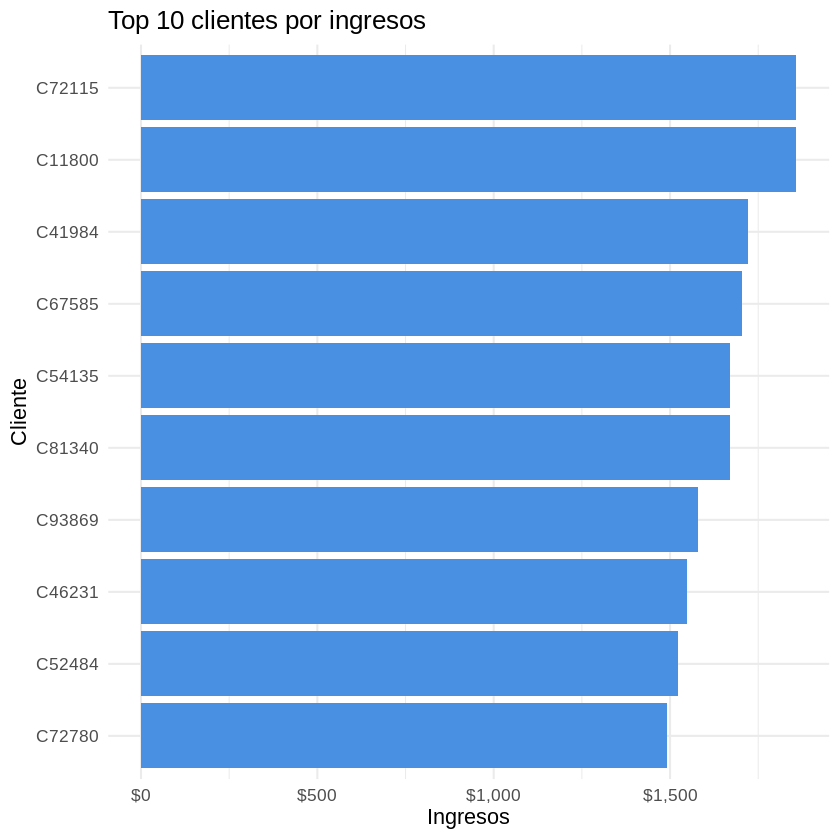

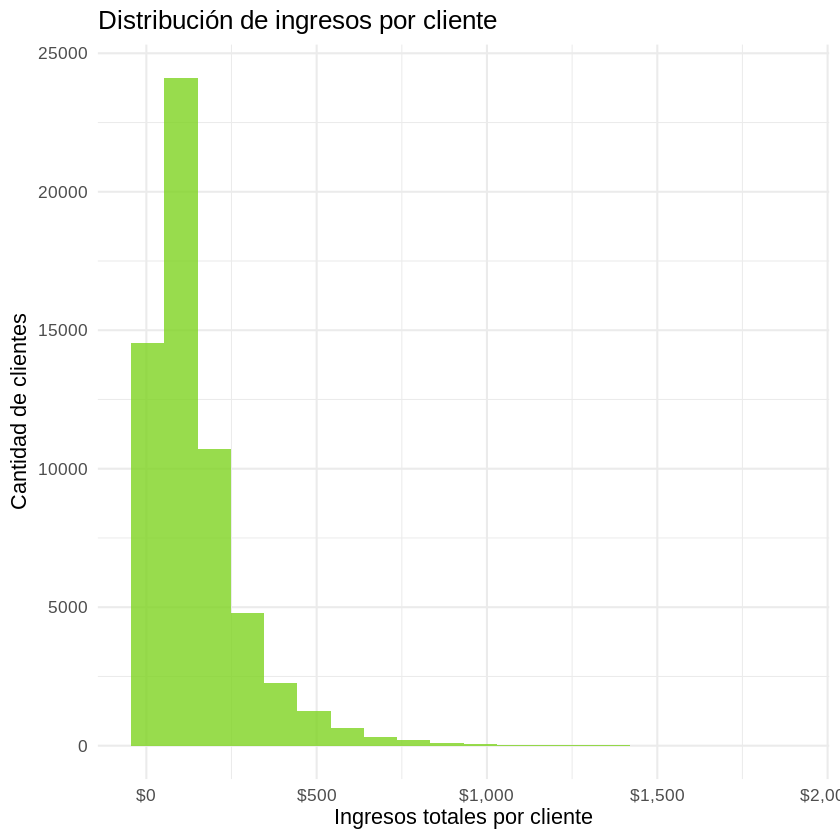

In [ ]:

# ------------------------------------------------------------
# C1) KPI clientes (solo compradores)
# ------------------------------------------------------------

clientes_kpi <- tx %>%
  filter(!is.na(customer_id)) %>%
  group_by(customer_id) %>%
  summarise(
    ingresos_totales = sum(gross_revenue, na.rm = TRUE),
    compras = n(),
    ticket_promedio = if_else(compras > 0, ingresos_totales / compras, NA_real_),
    .groups = "drop"
  )

top10_clientes <- clientes_kpi %>%
  arrange(desc(ingresos_totales)) %>%
  slice_head(n = 10)

ggplot(top10_clientes, aes(x = reorder(paste0("C", customer_id), ingresos_totales), y = ingresos_totales)) +
  geom_col(fill = "#4a90e2") +
  coord_flip() +
  scale_y_continuous(labels = dollar_format()) +
  labs(title = "Top 10 clientes por ingresos", x = "Cliente", y = "Ingresos") +
  theme_minimal(base_size = 13)

ggplot(clientes_kpi, aes(x = ingresos_totales)) +
  geom_histogram(bins = 20, fill = "#7ed321", alpha = 0.8) +
  scale_x_continuous(labels = dollar_format()) +
  labs(title = "Distribución de ingresos por cliente",
       x = "Ingresos totales por cliente", y = "Cantidad de clientes") +
  theme_minimal(base_size = 13)

# A tibble: 3 × 3
  grupo                             usuarios    pct
  <chr>                                <int>  <dbl>
1 Carrito (sin compra)                 38640 0.386 
2 Comprador                            58987 0.590 
3 Visitante (sin carrito ni compra)     2373 0.0237


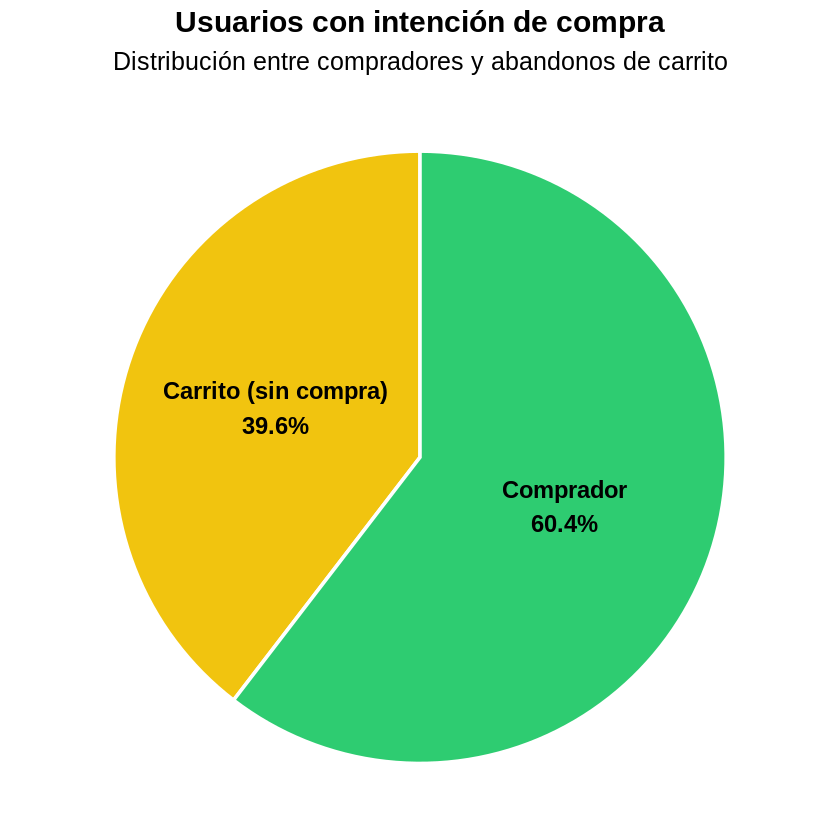

In [ ]:
# ------------------------------------------------------------
# C2) Funnel (Comprador vs Carrito sin compra vs Visitante)
# ------------------------------------------------------------

eventos_visita <- c("page_view", "visit", "view", "session_start")

u_compradores <- tx %>%
  filter(!is.na(customer_id)) %>%
  distinct(customer_id) %>%
  mutate(grupo = "Comprador")

u_carrito <- ev %>%
  filter(!is.na(customer_id), event_type == "add_to_cart") %>%
  distinct(customer_id) %>%
  anti_join(u_compradores, by = "customer_id") %>%
  mutate(grupo = "Carrito (sin compra)")

u_visitantes <- ev %>%
  filter(!is.na(customer_id), event_type %in% eventos_visita) %>%
  distinct(customer_id) %>%
  anti_join(u_compradores, by = "customer_id") %>%
  anti_join(u_carrito, by = "customer_id") %>%
  mutate(grupo = "Visitante (sin carrito ni compra)")

resumen_funnel <- bind_rows(u_compradores, u_carrito, u_visitantes) %>%
  count(grupo, name = "usuarios") %>%
  mutate(pct = usuarios / sum(usuarios))

print(resumen_funnel)

torta_compra_carrito <- resumen_funnel %>%
  filter(grupo %in% c("Comprador", "Carrito (sin compra)")) %>%
  mutate(
    pct_relativo = usuarios / sum(usuarios),
    label = paste0(grupo, "\n", percent(pct_relativo, accuracy = 0.1))
  )

ggplot(torta_compra_carrito, aes(x = "", y = usuarios, fill = grupo)) +
  geom_col(width = 1, color = "white", linewidth = 1) +
  coord_polar(theta = "y") +
  scale_fill_manual(values = c("Comprador" = "#2ecc71", "Carrito (sin compra)" = "#f1c40f")) +
  geom_text(aes(label = label), position = position_stack(vjust = 0.5),
            color = "black", size = 5, fontface = "bold") +
  labs(
    title = "Usuarios con intención de compra",
    subtitle = "Distribución entre compradores y abandonos de carrito"
  ) +
  theme_void(base_size = 15) +
  theme(plot.title = element_text(face = "bold", hjust = 0.5),
        plot.subtitle = element_text(hjust = 0.5),
        legend.position = "none")

In [ ]:
# ------------------------------------------------------------
# C3) Segmentación básica de clientes (cuantiles 75%)
# ------------------------------------------------------------

p_ingresos_alto <- quantile(clientes_kpi$ingresos_totales, 0.75, na.rm = TRUE)
p_compras_alta  <- quantile(clientes_kpi$compras, 0.75, na.rm = TRUE)

clientes_segmentados <- clientes_kpi %>%
  mutate(
    tipo_cliente = case_when(
      ingresos_totales >= p_ingresos_alto & compras >= p_compras_alta ~ "Cliente VIP",
      ingresos_totales >= p_ingresos_alto & compras <  p_compras_alta ~ "Alto valor ocasional",
      ingresos_totales <  p_ingresos_alto & compras >= p_compras_alta ~ "Frecuente bajo ticket",
      TRUE                                                            ~ "Cliente ocasional"
    )
  )

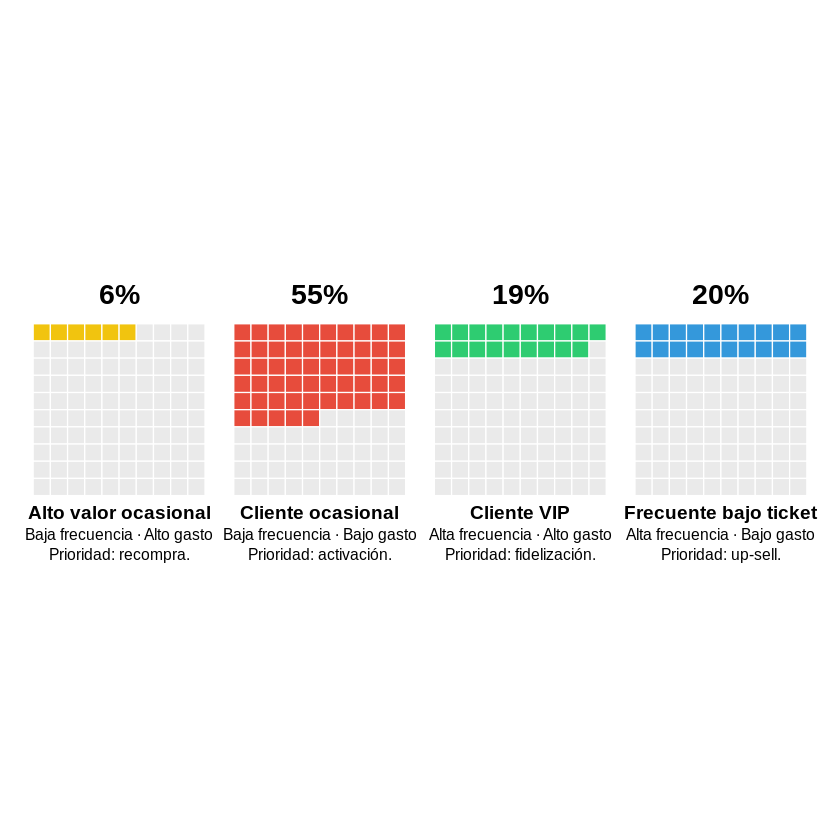

In [ ]:
# ------------------------------------------------------------
# C4) Waffle: distribución de segmentos
# ------------------------------------------------------------

waffle_base <- clientes_segmentados %>%
  count(tipo_cliente, name = "clientes") %>%
  mutate(
    pct = clientes / sum(clientes),
    raw = pct * 100,
    celdas = floor(raw),
    dec = raw - celdas
  )

faltan <- 100 - sum(waffle_base$celdas)
if (faltan > 0) {
  waffle_base <- waffle_base %>%
    arrange(desc(dec)) %>%
    mutate(celdas = celdas + if_else(row_number() <= faltan, 1L, 0L))
}

orden_panels <- c("Alto valor ocasional", "Cliente ocasional", "Cliente VIP", "Frecuente bajo ticket")
waffle_base <- waffle_base %>%
  mutate(tipo_cliente = factor(tipo_cliente, levels = orden_panels))

waffle_labels <- waffle_base %>%
  mutate(
    pct_lbl = percent(pct, accuracy = 1),
    titulo = as.character(tipo_cliente),
    texto = case_when(
      titulo == "Cliente VIP" ~ "Alta frecuencia · Alto gasto\nPrioridad: fidelización.",
      titulo == "Alto valor ocasional" ~ "Baja frecuencia · Alto gasto\nPrioridad: recompra.",
      titulo == "Frecuente bajo ticket" ~ "Alta frecuencia · Bajo gasto\nPrioridad: up-sell.",
      titulo == "Cliente ocasional" ~ "Baja frecuencia · Bajo gasto\nPrioridad: activación.",
      TRUE ~ ""
    ),
    x = 5.5
  )

grid_waffle <- tidyr::expand_grid(tipo_cliente = waffle_base$tipo_cliente, idx = 1:100) %>%
  left_join(waffle_base %>% select(tipo_cliente, celdas), by = "tipo_cliente") %>%
  mutate(
    filled = idx <= celdas,
    row = 10 - ((idx - 1) %/% 10),
    col = ((idx - 1) %% 10) + 1,
    fill_cat = if_else(filled, as.character(tipo_cliente), "Resto"),
    tipo_cliente = factor(tipo_cliente, levels = orden_panels)
  )

ggplot(grid_waffle, aes(x = col, y = row)) +
  geom_tile(aes(fill = fill_cat), color = "white", linewidth = 0.35) +
  facet_wrap(~ tipo_cliente, nrow = 1) +
  geom_text(data = waffle_labels, aes(x = x, y = 12.2, label = pct_lbl),
            inherit.aes = FALSE, size = 6, fontface = "bold") +
  geom_text(data = waffle_labels, aes(x = x, y = -0.5, label = titulo),
            inherit.aes = FALSE, size = 4, fontface = "bold") +
  geom_text(data = waffle_labels, aes(x = x, y = -2.3, label = texto),
            inherit.aes = FALSE, size = 3.3, lineheight = 1.05) +
  coord_equal(clip = "off") +
  scale_x_continuous(limits = c(0.5, 10.5), expand = c(0, 0)) +
  scale_y_continuous(limits = c(-3.2, 13), expand = c(0, 0)) +
  scale_fill_manual(values = c(
    "Cliente VIP" = "#2ecc71",
    "Alto valor ocasional" = "#f1c40f",
    "Frecuente bajo ticket" = "#3498db",
    "Cliente ocasional" = "#e74c3c",
    "Resto" = "#eaeaea"
  )) +
  theme_void(base_size = 13) +
  theme(strip.text = element_blank(),
        panel.spacing = unit(1.2, "lines"),
        legend.position = "none",
        plot.margin = margin(10, 20, 10, 20))


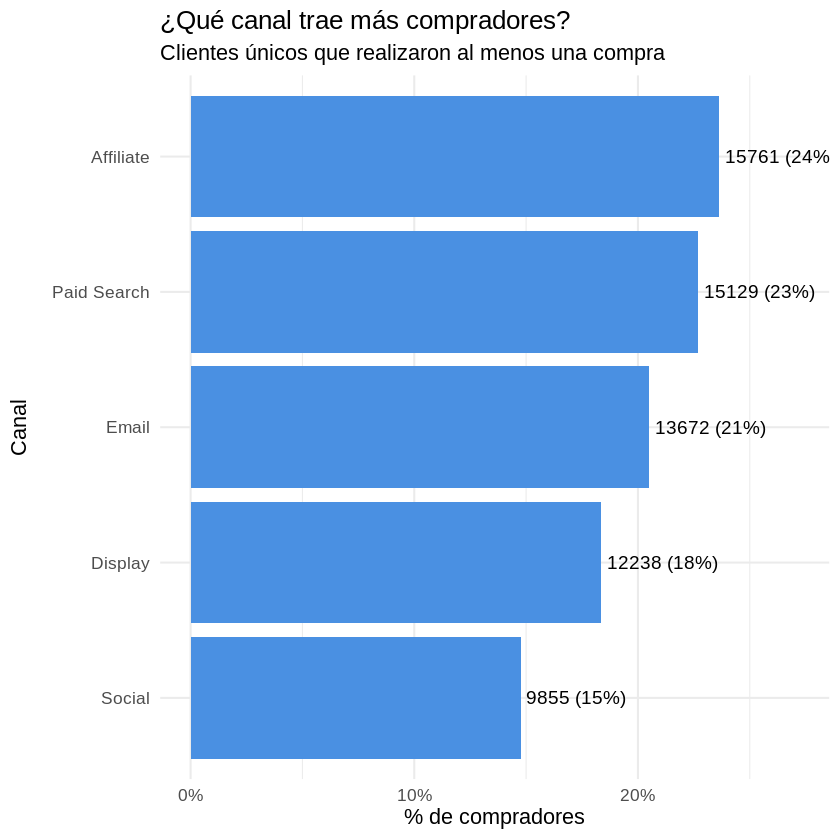

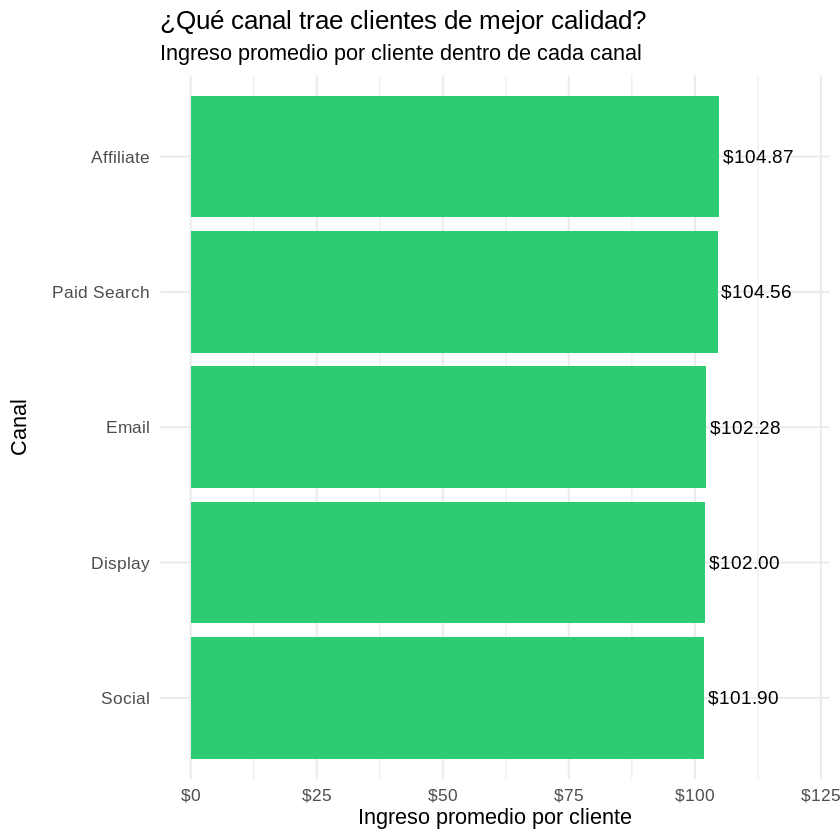

In [ ]:
# ------------------------------------------------------------
# C5) Clientes por canal: volumen + calidad
# ------------------------------------------------------------

tx_canal <- tx %>%
  select(customer_id, campaign_id, gross_revenue) %>%
  filter(!is.na(customer_id), !is.na(campaign_id), !is.na(gross_revenue)) %>%
  left_join(campaigns %>% select(campaign_id, channel), by = "campaign_id") %>%
  filter(!is.na(channel))

compradores_por_canal <- tx_canal %>%
  distinct(customer_id, channel) %>%
  count(channel, name = "compradores") %>%
  mutate(pct = compradores / sum(compradores)) %>%
  arrange(desc(compradores))

ggplot(compradores_por_canal, aes(x = reorder(channel, pct), y = pct)) +
  geom_col(fill = "#4a90e2") +
  coord_flip() +
  scale_y_continuous(labels = percent_format(accuracy = 1)) +
  geom_text(aes(label = paste0(compradores, " (", percent(pct, 1), ")")),
            hjust = -0.05, size = 4) +
  labs(
    title = "¿Qué canal trae más compradores?",
    subtitle = "Clientes únicos que realizaron al menos una compra",
    x = "Canal", y = "% de compradores"
  ) +
  theme_minimal(base_size = 13) +
  expand_limits(y = max(compradores_por_canal$pct) * 1.15)

ingreso_cliente_canal <- tx_canal %>%
  group_by(channel, customer_id) %>%
  summarise(
    ingresos_cliente = sum(gross_revenue, na.rm = TRUE),
    compras_cliente  = n(),
    .groups = "drop"
  )

calidad_por_canal <- ingreso_cliente_canal %>%
  group_by(channel) %>%
  summarise(
    clientes = n(),
    ingresos_totales = sum(ingresos_cliente),
    ingreso_promedio_cliente = mean(ingresos_cliente),
    mediana_ingreso_cliente  = median(ingresos_cliente),
    compras_promedio_cliente = mean(compras_cliente),
    .groups = "drop"
  ) %>%
  arrange(desc(ingreso_promedio_cliente))

ggplot(calidad_por_canal, aes(x = reorder(channel, ingreso_promedio_cliente), y = ingreso_promedio_cliente)) +
  geom_col(fill = "#2ecc71") +
  coord_flip() +
  scale_y_continuous(labels = dollar_format()) +
  geom_text(aes(label = dollar(ingreso_promedio_cliente)), hjust = -0.05, size = 4) +
  labs(
    title = "¿Qué canal trae clientes de mejor calidad?",
    subtitle = "Ingreso promedio por cliente dentro de cada canal",
    x = "Canal", y = "Ingreso promedio por cliente"
  ) +
  theme_minimal(base_size = 13) +
  expand_limits(y = max(calidad_por_canal$ingreso_promedio_cliente) * 1.15)

In [ ]:
# ------------------------------------------------------------
# CLIENTES - SUBSECCIóN GEOGRAFÍA
# ------------------------------------------------------------

# Base consistente: solo clientes ya segmentados (mismo universo que Clientes)
clientes_finales_ids <- clientes_segmentados %>% select(customer_id, tipo_cliente)

tx_por_pais <- tx %>%
  inner_join(clientes_finales_ids, by = "customer_id") %>%
  left_join(customers %>% select(customer_id, country), by = "customer_id") %>%
  filter(!is.na(country)) %>%
  group_by(country) %>%
  summarise(
    clientes_unicos = n_distinct(customer_id),
    ingresos_totales = sum(gross_revenue, na.rm = TRUE),
    ticket_promedio = if_else(n() > 0, ingresos_totales / n(), NA_real_),
    .groups = "drop"
  ) %>%
  arrange(desc(ingresos_totales))

# Validaciones de consistencia (evita interpretación equivocada)
message(paste("Clientes únicos (universo segmentado):", n_distinct(clientes_finales_ids$customer_id)))
message(paste("Clientes únicos con país informado:", sum(tx_por_pais$clientes_unicos))) # suma por país (no "únicos globales")


Clientes únicos (universo segmentado): 58987

Clientes únicos con país informado: 58987



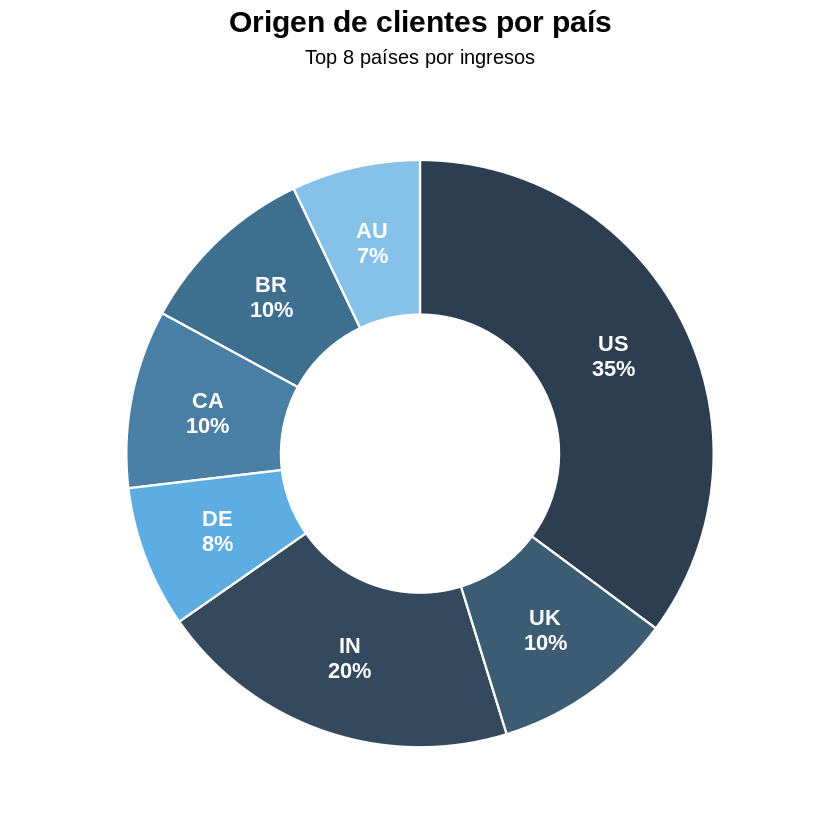

In [ ]:
# ------------------------------------------------------------
# C6) Dona: Distribución de ingresos por país
# ------------------------------------------------------------

top_n <- 8

data_dona <- tx_por_pais %>%
  mutate(country = as.character(country)) %>%
  mutate(rank_ingresos = row_number()) %>%
  mutate(grupo_pais = if_else(rank_ingresos <= top_n, country, "Otros")) %>%
  group_by(grupo_pais) %>%
  summarise(
    ingresos_totales = sum(ingresos_totales, na.rm = TRUE),
    clientes_unicos = sum(clientes_unicos, na.rm = TRUE),
    .groups = "drop"
  ) %>%
  mutate(
    pct_ingresos = ingresos_totales / sum(ingresos_totales),
    label = paste0(grupo_pais, "\n", percent(pct_ingresos, accuracy = 1))
  ) %>%
  arrange(desc(ingresos_totales))

paleta_paises <- c(
  "US" = "#2c3e50",
  "IN" = "#34495e",
  "UK" = "#3b5c73",
  "BR" = "#3f6f8f",
  "CA" = "#4a7fa5",
  "DE" = "#5dade2",
  "AU" = "#85c1e9",
  "Otros" = "#bdc3c7"
)

ggplot(data_dona, aes(x = 2, y = pct_ingresos, fill = grupo_pais)) +
  geom_col(color = "white", width = 1) +
  coord_polar(theta = "y", start = 0) +
  xlim(0.6, 2.6) +
  geom_text(
    aes(label = if_else(pct_ingresos >= 0.04, label, "")),
    position = position_stack(vjust = 0.5),
    color = "white",
    fontface = "bold",
    size = 4.6,
    lineheight = 0.95
  ) +
  scale_fill_manual(values = paleta_paises) +
  labs(
    title = "Origen de clientes por país",
    subtitle = paste0("Top ", top_n, " países por ingresos"),
    fill = "País"
  ) +
  theme_void(base_size = 14) +
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold", size = 18),
    plot.subtitle = element_text(hjust = 0.5, size = 12),
    legend.position = "none"
  )


In [ ]:
# ------------------------------------------------------------
# C7) Tabla: desempeño por país (Top 10 por ingresos)
# ------------------------------------------------------------

tabla_pais_metricas <- tx_por_pais %>%
  mutate(
    share_ingresos = ingresos_totales / sum(ingresos_totales),
    share_ingresos = percent(share_ingresos, accuracy = 0.1),
    ingresos_totales = dollar(ingresos_totales),
    ticket_promedio = dollar(ticket_promedio),
    clientes_unicos = comma(clientes_unicos)
  ) %>%
  rename(
    País = country,
    `Clientes únicos` = ,
    `Total ingresos` = ingresos_totales,
    `Ticket promedio` = ticket_promedio,
    `% Share ingresos` = share_ingresos
  )

print("--- RESUMEN GEOGRÁFICO DE CLIENTES---")
print(head(tabla_pais_metricas, 10))

[1] "--- RESUMEN GEOGRÁFICO DE CLIENTES---"
# A tibble: 7 × 5
  País  clientes_unicos `Total ingresos` `Ticket promedio` `% Share ingresos`
  <chr> <chr>           <chr>            <chr>             <chr>             
1 US    20,548          $3,033,489       $96.57            35.1%             
2 IN    11,815          $1,732,261       $95.76            20.1%             
3 UK    6,006           $869,993         $97.20            10.1%             
4 BR    5,968           $862,224         $94.86            10.0%             
5 CA    5,864           $846,893         $95.18            9.8%              
6 DE    4,631           $674,432         $94.91            7.8%              
7 AU    4,155           $610,977         $95.05            7.1%              
